---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train = pd.read_csv('train.csv', encoding = 'latin-1', low_memory = False)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
ticket_id                     250306 non-null int64
agency_name                   250306 non-null object
inspector_name                250306 non-null object
violator_name                 250272 non-null object
violation_street_number       250306 non-null float64
violation_street_name         250306 non-null object
violation_zip_code            0 non-null float64
mailing_address_str_number    246704 non-null float64
mailing_address_str_name      250302 non-null object
city                          250306 non-null object
state                         250213 non-null object
zip_code                      250305 non-null object
non_us_str_code               3 non-null object
country                       250306 non-null object
ticket_issued_date            250306 non-null object
hearing_date                  237815 non-null object
violation_code                250306 non-null obj

In [4]:
train.describe()

,ticket_id,violation_street_number,violation_zip_code,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance
count,250306.000000,2.503060e+05,0.0,2.467040e+05,250305.000000,250306.000000,250306.000000,250306.000000,250306.000000,250306.0,250306.000000,250306.000000,250306.000000,159880.000000
mean,152665.543099,1.064986e+04,NaN,9.149788e+03,374.423435,12.774764,6.387382,21.494506,0.125167,0.0,268.685356,48.898986,222.449058,0.072536
std,77189.882881,3.188733e+04,NaN,3.602034e+04,707.195807,9.607344,4.803672,56.464263,3.430178,0.0,626.915212,222.422425,606.394010,0.259374
min,18645.000000,0.000000e+00,NaN,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-7750.000000,0.000000
25%,86549.250000,4.739000e+03,NaN,5.440000e+02,200.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,152597.500000,1.024400e+04,NaN,2.456000e+03,250.000000,20.000000,10.000000,10.000000,0.000000,0.0,140.000000,0.000000,25.000000,0.000000
75%,219888.750000,1.576000e+04,NaN,1.292725e+04,250.000000,20.000000,10.000000,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
max,366178.000000,1.415411e+07,NaN,5.111345e+06,10000.000000,20.000000,10.000000,1000.000000,350.000000,0.0,11030.000000,11075.000000,11030.000000,1.000000


In [9]:
corr = train.corr()
corr

,ticket_id,violation_street_number,violation_zip_code,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance
ticket_id,1.000000,-0.002827,NaN,-0.003678,-0.002520,-0.038099,-0.038099,-0.005715,-0.019900,NaN,-0.012859,-0.048120,0.003718,-0.026264
violation_street_number,-0.002827,1.000000,NaN,0.013532,0.001184,0.002639,0.002639,0.003138,0.000531,NaN,0.003012,-0.000514,0.003301,-0.002526
violation_zip_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mailing_address_str_number,-0.003678,0.013532,NaN,1.000000,-0.009989,-0.000592,-0.000592,-0.007281,-0.001119,NaN,-0.007744,-0.013847,-0.002966,-0.010010
fine_amount,-0.002520,0.001184,NaN,-0.009989,1.000000,-0.032694,-0.032694,0.712581,0.029248,NaN,0.712200,0.185201,0.677729,-0.049134
admin_fee,-0.038099,0.002639,NaN,-0.000592,-0.032694,1.000000,1.000000,0.286289,0.027442,NaN,0.322319,0.139338,0.275884,NaN
state_fee,-0.038099,0.002639,NaN,-0.000592,-0.032694,1.000000,1.000000,0.286289,0.027442,NaN,0.322319,0.139338,0.275884,NaN
late_fee,-0.005715,0.003138,NaN,-0.007281,0.712581,0.286289,0.286289,1.000000,-0.013891,NaN,0.989371,0.198416,0.948404,-0.085055
discount_amount,-0.019900,0.000531,NaN,-0.001119,0.029248,0.027442,0.027442,-0.013891,1.000000,NaN,0.040895,0.148797,-0.018124,0.156073
clean_up_cost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


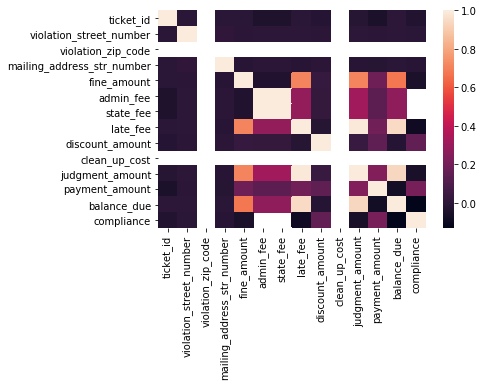

In [13]:
sns.heatmap(corr)

[Text(0, 0, 'Build, Safety Eng. & Env Dept'),
 Text(0, 0, 'Health Dept'),
 Text(0, 0, 'Dept Public Works'),
 Text(0, 0, 'Detroit Police Dept'),
 Text(0, 0, "N'hood City Halls")]

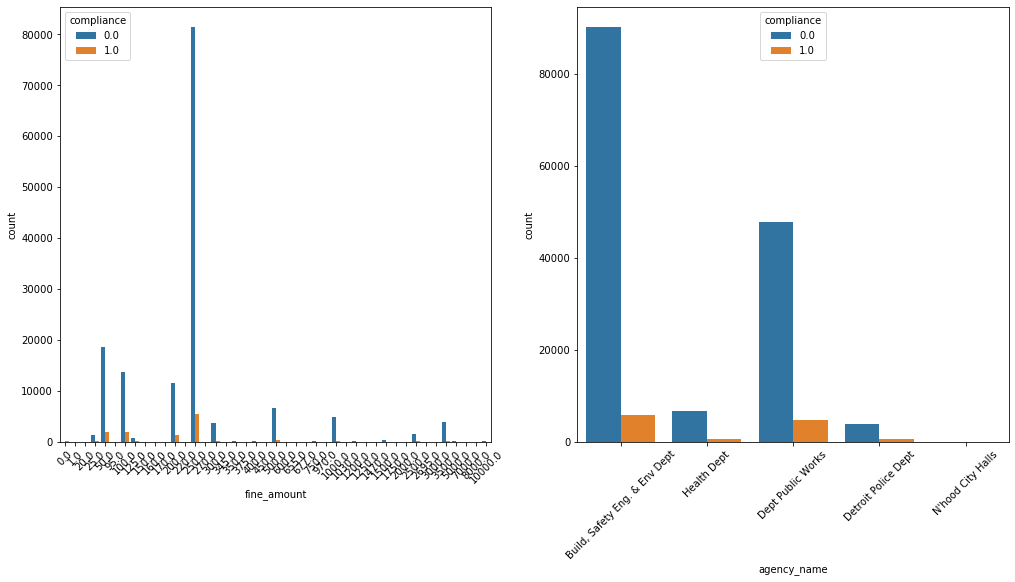

In [188]:
%matplotlib inline

fig, axes = plt.subplots(1,2, figsize = (17,8))

sns.countplot(x = 'fine_amount', hue = 'compliance', ax = axes[0], data = train)
sns.countplot(x = 'agency_name', hue = 'compliance', ax = axes[1], data = train)


axes[0].set_xticklabels(labels = axes[0].get_xticklabels(),rotation=45)
axes[1].set_xticklabels(labels = ['Build, Safety Eng. & Env Dept', "Health Dept", 
                               "Dept Public Works","Detroit Police Dept",
                               "N'hood City Halls"], rotation = 45)

(0, 30000)

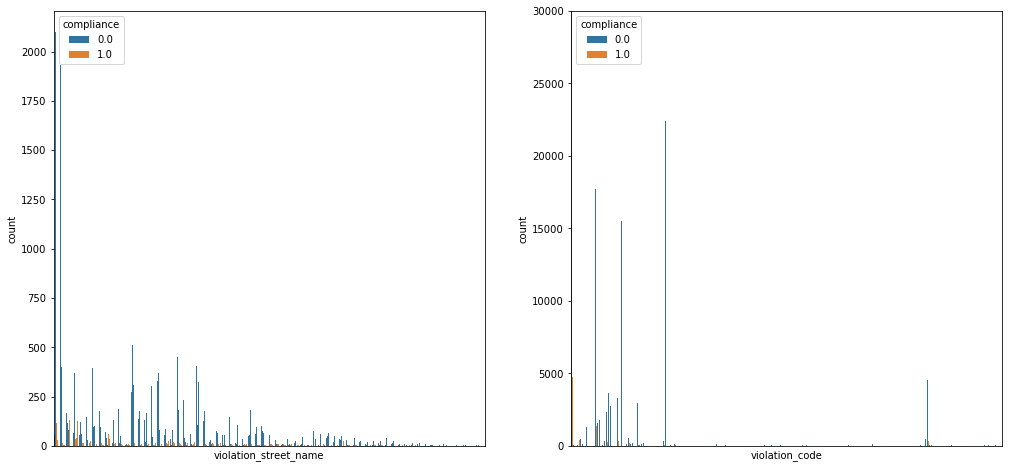

In [192]:
fig, axes = plt.subplots(1,2, figsize = (17,8))
sns.countplot(x = 'violation_street_name', hue = 'compliance', ax = axes[0], data = train)
axes[0].set_xticklabels(labels = [])
axes[0].set_xticks([])

sns.countplot(x = 'violation_code', hue = 'compliance', ax = axes[1], data = train)
axes[1].set_xticklabels(labels = [])
axes[1].set_xticks([])
axes[1].set_yticks(np.arange(0,30001,5000))
axes[1].set_ylim(0,30000)

In [18]:
latlons = pd.read_csv('latlons.csv')
latlons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121769 entries, 0 to 121768
Data columns (total 3 columns):
address    121769 non-null object
lat        121762 non-null float64
lon        121762 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.8+ MB


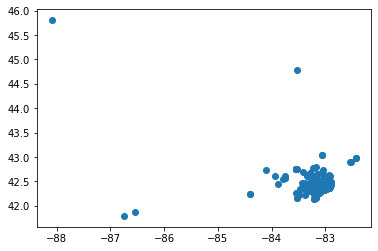

In [24]:
latlons.describe()
plt.scatter(latlons['lon'],latlons['lat'])

In [28]:
addresses = pd.read_csv('addresses.csv')
addresses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311307 entries, 0 to 311306
Data columns (total 2 columns):
ticket_id    311307 non-null int64
address      311307 non-null object
dtypes: int64(1), object(1)
memory usage: 4.8+ MB


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


def pre_process_data():
    
        df = pd.read_csv('train.csv', encoding = 'latin-1', low_memory = False)
        latlons = pd.read_csv('latlons.csv')
        addresses = pd.read_csv('addresses.csv')
        
        df = (df.merge(addresses.merge(latlons,
                               how='left',
                               on= 'address'),
             how = 'left',
             on = 'ticket_id'))
        #merge together train.csv with latlons and addresses
        
        df.drop(['agency_name', 'violator_name', 'non_us_str_code', 'violation_description',
                 'grafitti_status', 'state_fee', 'admin_fee', 'payment_amount', 'balance_due', 
                 'payment_date', 'payment_status','collection_status', 'compliance_detail', 
                 'violation_zip_code', 'country', 'address','violation_street_number', 'hearing_date',
                 'violation_street_name', 'mailing_address_str_number', 'mailing_address_str_name',
                 'city','state', 'zip_code', 'address'], 
                axis = 1,
                inplace = True)
        
        for col in df.columns[df.dtypes == 'object']:
            df[col] = LabelEncoder().fit_transform(df[col])
        
        #transform categorical variables so they can be used with algorithm
        
        df = df.dropna()
        df = df[['ticket_id','inspector_name','violation_code','disposition', 'fine_amount', 'late_fee',
                 'clean_up_cost','discount_amount','judgment_amount','ticket_issued_date','lat', 'lon',
                 'compliance']]
        
        X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1],
                                                         df.iloc[:,-1],
                                                        test_size = 0.33,
                                                        random_state = 0)
        #create train-test split of the data
        
        return X_train, X_test, y_train, y_test

In [24]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score

def blight_model():

    
    def clean_data_test():
        test = pd.read_csv('test.csv',encoding = 'latin-1',low_memory = False)

        #state_MI_dummy = pd.get_dummies(train['state'])['MI']
        #country_USA_dummy = pd.get_dummies(train['country'])['USA']

        seven_mile_dummy = pd.get_dummies(test['violation_street_name'])["SEVEN MILE"]
        mcnichols_dummy = pd.get_dummies(test['violation_street_name'])["MCNICHOLS"]
        livernois_dummy = pd.get_dummies(test['violation_street_name'])["LIVERNOIS"]
        bseed_dummy = pd.get_dummies(test['agency_name'])['Buildings, Safety Engineering & Env Department']
        dpw_dummy = pd.get_dummies(test['agency_name'])['Department of Public Works']
        dpolice_dummy = pd.get_dummies(test['agency_name'])['Detroit Police Department']
        #dhealth_dummy = pd.get_dummies(test['agency_name'])['Health Department']

        nineonethirtysixa_dummy = pd.get_dummies(test['violation_code'])['9-1-36(a)']
        nineoneeightyonea_dummy = pd.get_dummies(test['violation_code'])['9-1-81(a)']
        twentytwoeightyeight_dummy = pd.get_dummies(test['violation_code'])['22-2-88']
        #investment_acorn = pd.get_dummies(train['violator_name'])['INVESTMENT, ACORN']

        #train['state_MI_dummy'] = state_MI_dummy.values
        #train['country_USA_dummy'] = country_USA_dummy.values
        test['seven_mile_dummy'] = seven_mile_dummy.values
        test['mcnichols_dummy'] = mcnichols_dummy.values
        test['livernois_dummy'] = livernois_dummy.values
        test['bseed_dummy'] = bseed_dummy.values
        test['dpw_dummy'] = dpw_dummy.values
        test['dpolice_dummy'] = dpolice_dummy.values
        #test['dhealth_dummy'] = dhealth_dummy.values
        test['nineonethirtysixa_dummy'] = nineonethirtysixa_dummy.values
        test['nineoneeightyonea_dummy'] =nineoneeightyonea_dummy.values
        test['twentytwoeightyeight_dummy'] = twentytwoeightyeight_dummy.values

        #train['investment_acorn_dummy'] = investment_acorn.values

        #violator_name_encoded_dummy = LabelEncoder().fit_transform(train['violator_name'].astype(str))

        test1 = test[['ticket_id','fine_amount','discount_amount','judgment_amount','seven_mile_dummy','bseed_dummy','dpw_dummy','dpolice_dummy','nineonethirtysixa_dummy','nineoneeightyonea_dummy','twentytwoeightyeight_dummy']]
        test2 = test1.dropna()

        X_test = test2[['fine_amount','discount_amount','judgment_amount','seven_mile_dummy','bseed_dummy','dpw_dummy','dpolice_dummy','nineonethirtysixa_dummy','nineoneeightyonea_dummy','twentytwoeightyeight_dummy']]

        return X_test, test2

    X_train, y_train = clean_data_train()
    X_test, test2 = clean_data_test()

    logreg = LogisticRegression(n_jobs = -1, C = 0.01, penalty = 'l2').fit(X_train,y_train)
    probabilities = pd.Series(logreg.predict_proba(X_test)[:,1], index = test2['ticket_id'])
    return probabilities

In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
import xgboost
from sklearn.preprocessing import StandardScaler

def pick_classifier():
    
    X_train, X_test, y_train, y_test = pre_process_data()
    
    classifiers = []
    
    model1 = LogisticRegression(solver = 'liblinear')
    classifiers.append(model1)
        
    model2 = DecisionTreeClassifier(max_features = 'auto')
    classifiers.append(model2)
        
    model4 = RandomForestClassifier()
    classifiers.append(model4)
    
    model5 = xgboost.XGBClassifier()
    classifiers.append(model5)
    
    model6 = AdaBoostClassifier()
    classifiers.append(model6)
    
    model7 = GaussianNB()
    classifiers.append(model7)
    
    for clf in classifiers:
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test,y_pred)
        print("Accuracy of {} is: {}".format(clf,acc))
        cm = confusion_matrix(y_test,y_pred)
        print("Confusion Matrix of {} is \n{}".format(clf,cm))
        try:
            print("ROC_AUC score: {}".format(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])))
        except:
            print("ROC_AUC score: {}".format(roc_auc_score(y_test,clf.decision_function(X_test))))
    
pick_classifier()

Accuracy of LogisticRegression(solver='liblinear') is: 0.9307808946171342
Confusion Matrix of LogisticRegression(solver='liblinear') is 
[[48815   134]
 [ 3518   293]]
ROC_AUC score: 0.7579533443467116
Accuracy of DecisionTreeClassifier(max_features='auto') is: 0.9100833965125095
Confusion Matrix of DecisionTreeClassifier(max_features='auto') is 
[[46577  2372]
 [ 2372  1439]]
ROC_AUC score: 0.6645662918246608
Accuracy of RandomForestClassifier() is: 0.9405989385898408
Confusion Matrix of RandomForestClassifier() is 
[[48412   537]
 [ 2597  1214]]
ROC_AUC score: 0.8088792463234498
Accuracy of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num

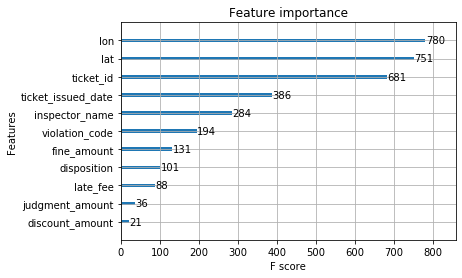

In [44]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier, plot_importance
from matplotlib import pyplot as plt
from matplotlib import rcParams

%matplotlib inline

def plot_features():
    
    X_train, X_test, y_train, y_test = pre_process_data()
        
    clf = XGBClassifier()
    clf.fit(X_train,y_train)
    
    plot_importance(clf)
    plt.show()
        
plot_features()    

In [18]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pylab as plt

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost.sklearn import XGBClassifier, plot importance

%matplotlib inline

def modelfit(clf, X_train, y_train, X_test,y_test, predictors, 
             useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = clf.get_xgb_params() 
        #get list of parameters used by the classifier
        
        xgtrain = xgb.DMatrix(X_train[predictors].values, label = y_train.values) 
        #create a dmatrix with training labels
        
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round = clf.get_params()['n_estimators'], 
                          nfold =  cv_folds, 
                          metrics='auc', 
                          early_stopping_rounds = early_stopping_rounds)
        
        #randomly partition original sample into 5 equal subsamples, 
        #1 sample is retained as the validation set, 
        #4 subsamples are used as the training set
        #cross validation is repeated num_boost_round times with each of the 
        #subsamples used once as the validation set
        
        clf.set_params(n_estimators=cvresult.shape[0])
        #set the new optimal estimators based on the cross-validation
    
    #Fit the algorithm to the data
    clf.fit(X_train[predictors], y_train, eval_metric='auc')
        
    #Predict training set:
    X_train_predictions = clf.predict(X_train[predictors])
    X_train_predprob = clf.predict_proba(X_train[predictors])[:,1]
    
    #predict test set:
    X_test_predictions = clf.predict(X_test[predictors])
    X_test_predprob = clf.predict_proba(X_test[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print("best iteration: %.4g" % cvresult.shape[0])
    print ("Accuracy (Train): %.4g" % accuracy_score(y_train.values, X_train_predictions))
    print ("Accuracy (Test): %.4g" % accuracy_score(y_test.values, X_test_predictions))
    
    print ("AUC Score (Train): %f" % roc_auc_score(y_train, X_train_predprob))
    print ("AUC Score (Test): %f" % roc_auc_score(y_test, X_test_predprob))
                    
    plot_importance(clf)

# Instantiate XGBoost Classifier with default parameters and call modelfit function to find the optimal number of estimators


Model Report
best iteration: 139
Accuracy (Train): 0.9472
Accuracy (Test): 0.9439
AUC Score (Train): 0.884512
AUC Score (Test): 0.832385
None


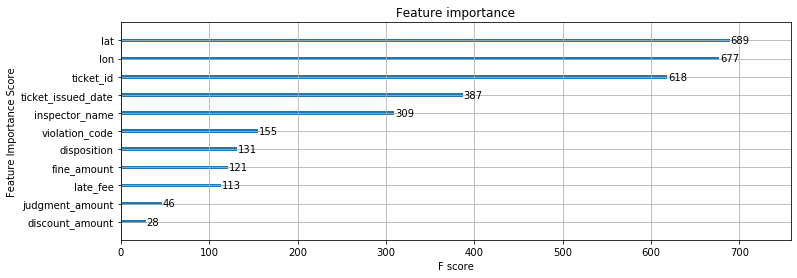

In [45]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier

def parameter_tuning():
    
        X_train, X_test, y_train, y_test = pre_process_data()
        
        clf = XGBClassifier(learning_rate = 0.2, 
                            n_estimators = 1000, 
                            max_depth = 5, 
                            min_child_weight = 1, 
                            gamma = 0, 
                            subsample = 0.8, 
                            colsamply_bytree = 0.8,
                            objective = 'binary:logistic', 
                            scale_pos_weight = 1, 
                            seed = 27,
                            verbosity = 0)
        
        predictors = [x for x in X_train.columns]
        
        print(modelfit(clf, X_train, y_train, X_test, y_test, predictors))
        
parameter_tuning()

# Run GridSearch to find the optimal max_depth and min_child_weight parameters

In [21]:
from sklearn.model_selection import cross_validate, GridSearchCV

def param_test_1():
    
    X_train, X_test, y_train, y_test = pre_process_data()

    param_test1 = {
     'max_depth':range(3,10,2),
     'min_child_weight':range(1,6,2)
    }

    gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.2, 
                                                      n_estimators=139, 
                                                      max_depth=5,
                                                      min_child_weight=1, 
                                                      gamma=0, 
                                                      subsample=0.8, 
                                                      colsample_bytree=0.8,
                                                      objective= 'binary:logistic', 
                                                      nthread=4, 
                                                      scale_pos_weight=1, 
                                                      seed=27,
                                                      verbosity = 0),
                            param_grid = param_test1, 
                            scoring='roc_auc',
                            n_jobs=4,
                            cv=5)

    gsearch1.fit(X_train,y_train)
    keys = ['mean_fit_time','std_fit_time','mean_score_time','std_score_time']
    print([gsearch1.cv_results_[key] for key in keys], gsearch1.best_params_, gsearch1.best_score_)

param_test_1()

[array([24.94272885, 23.66393867, 18.82806277, 27.1176065 , 40.08832393,
       35.23128438, 39.50003195, 39.63655601, 33.82476158, 45.02374821,
       43.95705266, 32.13513989]), array([ 2.05478196,  2.07225299,  1.86692655,  3.42829584,  5.14556157,
        6.31111338,  5.22563762,  5.9056006 ,  3.88340387,  5.70944848,
        5.04738991, 10.38995743]), array([0.07321572, 0.07531261, 0.08136201, 0.09293036, 0.11792798,
       0.10005546, 0.12474103, 0.12158308, 0.11722589, 0.14227715,
       0.14935575, 0.1031692 ]), array([0.00718043, 0.01339821, 0.0121105 , 0.00962174, 0.02406708,
       0.01230632, 0.00901198, 0.01241138, 0.01390803, 0.01214711,
       0.01389172, 0.03680509])] {'max_depth': 7, 'min_child_weight': 1} 0.8293908135932779


# Run GridSearch again on max_depth and min_child_weight and shrink the interval step to 1

In [22]:
from sklearn.model_selection import cross_validate, GridSearchCV

def param_test_2():
    
    X_train, X_test, y_train, y_test = pre_process_data()

    param_test2 = {
     'max_depth':[6,7,8],
     'min_child_weight':[0,1,2]
    }
    
    gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, 
                                                      n_estimators=139, 
                                                      max_depth=5,
                                                      min_child_weight=1, 
                                                      gamma=0, 
                                                      subsample=0.8, 
                                                      colsample_bytree=0.8,
                                                      objective= 'binary:logistic', 
                                                      nthread=4, 
                                                      scale_pos_weight=1,
                                                      seed=27,
                                                      verbosity = 0), 
                            param_grid = param_test2, 
                            scoring='roc_auc',
                            n_jobs=4,
                            cv=5)
    
    gsearch2.fit(X_train,y_train)
    keys = ['mean_fit_time','std_fit_time','mean_score_time','std_score_time']
    print([gsearch2.cv_results_[key] for key in keys], gsearch2.best_params_, gsearch2.best_score_)
    
param_test_2()

[array([34.35321088, 32.93334241, 41.47175689, 41.71742806, 37.86629782,
       41.56553035, 49.94718881, 46.91231084, 46.30395665]), array([3.70080352, 2.7555564 , 5.32693797, 9.54900656, 5.07311576,
       5.41636537, 3.62931223, 5.22610729, 9.14901681]), array([0.11251559, 0.12654471, 0.11766376, 0.1248127 , 0.12243023,
       0.12497296, 0.14290543, 0.15973802, 0.10217791]), array([0.01720804, 0.00982734, 0.01820135, 0.01575633, 0.01731311,
       0.01154109, 0.01188373, 0.01166043, 0.03853447])] {'max_depth': 6, 'min_child_weight': 0} 0.8317564634486704


# Update max_depth and min_child_weight parameters. 
# GridSearch for the optimal value for Gamma

In [23]:
def param_test_3():
    
    X_train, X_test, y_train, y_test = pre_process_data()    
    
    param_test3 = {
     'gamma':[i/10.0 for i in range(0,5)]
    }
    
    gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.2, 
                                                      n_estimators=139, 
                                                      max_depth=6,
                                                      min_child_weight=0, 
                                                      gamma=0, 
                                                      subsample=0.8, 
                                                      colsample_bytree=0.8,
                                                      objective= 'binary:logistic', 
                                                      nthread=4, 
                                                      scale_pos_weight=1,
                                                      seed=27,
                                                      verbosity = 0), 
                            param_grid = param_test3, 
                            scoring='roc_auc',
                            n_jobs=4,
                            cv=5)
    
    gsearch3.fit(X_train,y_train)
    keys = ['mean_fit_time','std_fit_time','mean_score_time','std_score_time']
    print([gsearch3.cv_results_[key] for key in keys], gsearch3.best_params_, gsearch3.best_score_)
    
param_test_3()

[array([43.53328924, 41.52928843, 40.4370235 , 39.72479978, 35.31773219]), array([10.46930671,  2.27580306,  4.04596782,  4.71494944,  9.30644898]), array([0.10979524, 0.11470785, 0.11590033, 0.1161284 , 0.0944643 ]), array([0.00680541, 0.00642442, 0.01000792, 0.00547742, 0.02449531])] {'gamma': 0.0} 0.8317564634486704


# Update Gamma
# Call modelfit function to update the number of estimators


Model Report
best iteration: 132
Accuracy (Train): 0.9501
Accuracy (Test): 0.9442
AUC Score (Train): 0.911779
AUC Score (Test): 0.834882
None


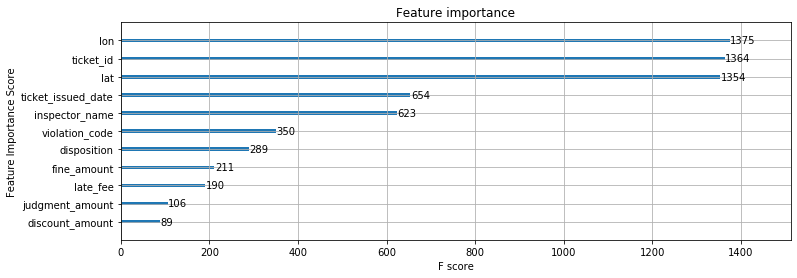

In [25]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier

def parameter_tuning1():
    
        X_train, X_test, y_train, y_test = pre_process_data()
        
        clf = XGBClassifier(learning_rate =0.2, 
                            n_estimators =1000, 
                            max_depth = 6, 
                            min_child_weight = 0, 
                            gamma = 0, 
                            subsample = 0.8, 
                            colsamply_bytree = 0.8,
                            objective = 'binary:logistic', 
                            scale_pos_weight = 1, 
                            seed = 27,
                            verbosity = 0)
        
        predictors = [x for x in X_train.columns]
        
        print(modelfit(clf, X_train, y_train, X_test, y_test, predictors))
        
parameter_tuning1()

# Update n_estimators
# GridSearch for optimal values of subsample and colsample_bytree

In [26]:
def param_test_4():
    
    X_train, X_test, y_train, y_test = pre_process_data()
    
    param_test4 = {
     'subsample':[i/10.0 for i in range(6,10)],
     'colsample_bytree':[i/10.0 for i in range(6,10)]
    }
    gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.2, 
                                                      n_estimators=132, 
                                                      max_depth=6,
                                                      min_child_weight=0,
                                                      gamma=0, 
                                                      subsample=0.8, 
                                                      colsample_bytree=0.8,
                                                      objective= 'binary:logistic', 
                                                      nthread=4, 
                                                      scale_pos_weight=1,
                                                      seed=27,
                                                      verbosity = 0), 
                            param_grid = param_test4, 
                            scoring='roc_auc',
                            n_jobs=4,
                            cv=5)
    
    gsearch4.fit(X_train,y_train)
    
    keys = ['mean_fit_time','std_fit_time','mean_score_time','std_score_time']
    
    print([gsearch4.cv_results_[key] for key in keys], gsearch4.best_params_, gsearch4.best_score_)
    
param_test_4()

[array([38.38461342, 39.33132858, 40.16289067, 34.80053139, 35.2063086 ,
       36.09170866, 33.08210711, 29.52269702, 40.22961674, 31.99614825,
       33.67402816, 30.09442892, 38.41106844, 40.55785813, 41.42607026,
       22.98073959]), array([ 5.06586749,  9.14843097,  8.16628874,  4.36405009,  3.63367733,
        5.64104336,  5.02544859,  3.12481889,  7.453415  ,  3.00901881,
        9.28410782,  2.09129952,  5.75633255,  5.90827822,  3.38713088,
       12.39103887]), array([0.10552964, 0.11671023, 0.10881958, 0.10005112, 0.10274601,
       0.1112112 , 0.1112977 , 0.0986908 , 0.09720116, 0.11167345,
       0.09825249, 0.11152029, 0.12355494, 0.11930971, 0.10709209,
       0.07917991]), array([0.01274089, 0.01260906, 0.01734455, 0.01145026, 0.0142359 ,
       0.01046365, 0.008384  , 0.01490507, 0.00777564, 0.0099807 ,
       0.01179489, 0.01328199, 0.01706824, 0.02432705, 0.01334866,
       0.03819836])] {'colsample_bytree': 0.8, 'subsample': 0.9} 0.8328168497128251


# Repeat GridSearch with smaller intervals and smaller step

In [27]:
def param_test_5():
    
    X_train, X_test, y_train, y_test = pre_process_data()

    param_test5 = {
     'subsample':[i/100.0 for i in range(75,86,5)],
     'colsample_bytree':[i/100.0 for i in range(85,96,5)]
    }
    
    gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.2, 
                                                      n_estimators=132,
                                                      max_depth=6,
                                                      min_child_weight=0, 
                                                      gamma=0, 
                                                      subsample=0.8, 
                                                      colsample_bytree=0.8,
                                                      objective= 'binary:logistic', 
                                                      nthread=4, 
                                                      scale_pos_weight=1,
                                                      seed=27,
                                                      verbosity = 0), 
                            param_grid = param_test5, 
                            scoring='roc_auc',
                            n_jobs=4,
                            cv=5)
    
    gsearch5.fit(X_train,y_train)
    keys = ['mean_fit_time','std_fit_time','mean_score_time','std_score_time']
    
    print([gsearch5.cv_results_[key] for key in keys], gsearch5.best_params_, gsearch5.best_score_)
    
param_test_5()

[array([40.0679565 , 34.63502059, 32.5679749 , 36.02616072, 36.23813496,
       30.60757799, 38.81150036, 33.14004011, 23.79491057]), array([ 5.86559806,  2.00280908,  5.5069993 , 10.30249825,  8.44633828,
        2.44670873, 10.21019807,  2.93837558,  8.50919449]), array([0.11218805, 0.10529332, 0.09881272, 0.09860406, 0.12238684,
       0.10252385, 0.10708275, 0.10796738, 0.07065105]), array([0.01943401, 0.01028062, 0.01705909, 0.01417055, 0.00910921,
       0.01198378, 0.01669859, 0.01779528, 0.03372102])] {'colsample_bytree': 0.85, 'subsample': 0.85} 0.8315933474293683


# Update subsample and colsample_bytree
# GridSearch for optimal values of reg_alpha 

In [28]:
def param_test_6():
    
    X_train, X_test, y_train, y_test = pre_process_data()

    param_test6 = {
     'reg_alpha':[1e-5,1e-2,0.1,1,100],
    }
    
    gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.2, 
                                                      n_estimators=132,
                                                      max_depth=6,
                                                      min_child_weight=0, 
                                                      gamma=0, 
                                                      subsample=0.85, 
                                                      colsample_bytree=0.85,
                                                      objective= 'binary:logistic', 
                                                      nthread=4, 
                                                      scale_pos_weight=1,
                                                      seed=27,
                                                      verbosity = 0), 
                            param_grid = param_test6, 
                            scoring='roc_auc',
                            n_jobs=4,
                            cv=5)
    
    gsearch6.fit(X_train,y_train)
    keys = ['mean_fit_time','std_fit_time','mean_score_time','std_score_time']
    
    print([gsearch6.cv_results_[key] for key in keys], gsearch6.best_params_, gsearch6.best_score_)
    
param_test_6()

[array([46.65255604, 41.76222172, 37.66832724, 36.24699054, 18.03074059]), array([8.42705296, 6.79977047, 4.12439511, 7.78335577, 7.88800987]), array([0.10555897, 0.10313988, 0.10233202, 0.11029739, 0.06333418]), array([0.00655194, 0.01025129, 0.01099476, 0.00998639, 0.03183319])] {'reg_alpha': 1} 0.8326680314242308


# Repeat GridSearch with smaller step

In [29]:
def param_test_7():
    
    X_train, X_test, y_train, y_test = pre_process_data()

    param_test7 = {
     'reg_alpha':[10,1.0,0.1,0.01],
    }
    
    gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.2, 
                                                      n_estimators=132,
                                                      max_depth=6,
                                                      min_child_weight=0, 
                                                      gamma=0, 
                                                      subsample=0.85, 
                                                      colsample_bytree=0.85,
                                                      objective= 'binary:logistic', 
                                                      nthread=4, 
                                                      scale_pos_weight=1,
                                                      seed=27,
                                                      verbosity = 0), 
                            param_grid = param_test7, 
                            scoring='roc_auc',
                            n_jobs=4,
                            cv=5)
    
    gsearch7.fit(X_train,y_train)
    keys = ['mean_fit_time','std_fit_time','mean_score_time','std_score_time']

    print([gsearch7.cv_results_[key] for key in keys], gsearch7.best_params_, gsearch7.best_score_)
    
param_test_7()

[array([41.5274981 , 35.91096997, 38.18235393, 32.85735474]), array([4.79307601, 4.57850107, 6.59736493, 7.68557502]), array([0.11217957, 0.10533848, 0.11271815, 0.06712832]), array([0.00349844, 0.01712265, 0.01172487, 0.02306719])] {'reg_alpha': 1.0} 0.8326680314242308


# Reduce the learning rate and increase number of estimators


Model Report
best iteration: 1585
Accuracy (Train): 0.95
Accuracy (Test): 0.9443
AUC Score (Train): 0.924170
AUC Score (Test): 0.840797
None


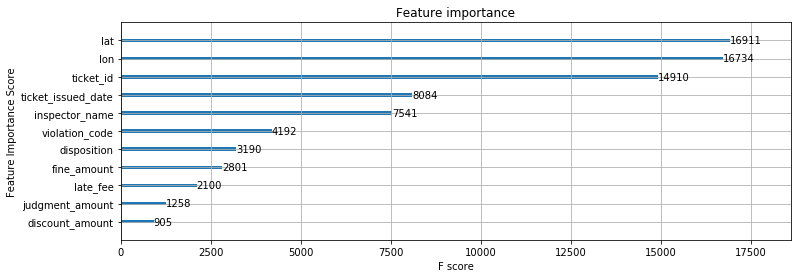

In [30]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier

def parameter_tuning2():
    
        X_train, X_test, y_train, y_test = pre_process_data()
        
        clf = XGBClassifier(learning_rate =0.02, 
                            n_estimators =5000, 
                            max_depth = 6, 
                            min_child_weight = 0, 
                            gamma = 0, 
                            subsample = .85, 
                            colsamply_bytree = .85,
                            reg_alpha=1,
                            objective = 'binary:logistic', 
                            scale_pos_weight = 1, 
                            seed = 27,
                            verbosity = 0)
        
        predictors = [x for x in X_train.columns]   
        
        print(modelfit(clf, X_train, y_train, X_test, y_test, predictors))
        
parameter_tuning2()